In [1]:
import numpy as np
import torch
import sys, os

sys.path.append("../")
import matplotlib.pyplot as plt

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

%matplotlib inline

### Loading data

We will use the `pytorch` `Dataset` class for handling the data.

Here we wil load some data of 20 artificial neurons that are implementing a noisy oscillator. This data is an array of dimensions `num_trials x num_units x sequence_length`, which we use to initialise a `Basic_dataset_with_trials`.

If one has data without trial structure one can instead initialise the `Basic_dataset` class using an array of dimensions `num_units x sequence_length`.

In [2]:
from vi_rnn.datasets import Basic_dataset_with_trials

In [3]:
# load data
data_all = np.load("tutorial_data/continuous_data.npy")
n_trials, dim_x, seq_len = data_all.shape

# split into train and eval
train_inds = np.full((n_trials,), False)
train_inds[np.random.choice(np.arange(200), size=150, replace=False)] = True
data_train = data_all[train_inds]
data_eval = data_all[~train_inds]


# initialise a dataset class
task_params = {"name": "tutorial_cont"}
dataset = Basic_dataset_with_trials(
    task_params=task_params,
    data=data_train,
    data_eval=data_eval,
    stim=None,  # you could additionally pass stimuli like this
    stim_eval=None,
)

In [5]:
data_train.shape

(150, 20, 75)

Text(0.5, 1.0, 'activity in trial 2')

findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, san

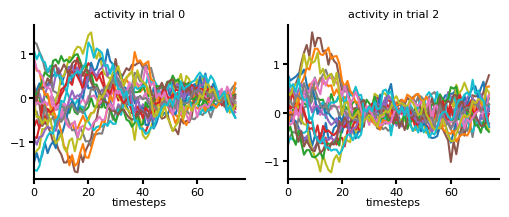

In [4]:
# plot some example data
fig, ax = plt.subplots(1, 2, figsize=(6, 2))
ax[0].plot(dataset.data[0].T)
ax[1].plot(dataset.data[2].T)
ax[0].set_xlim(0)
ax[1].set_xlim(0)
ax[0].set_xlabel("timesteps")
ax[1].set_xlabel("timesteps")
ax[0].set_title("activity in trial 0")
ax[1].set_title("activity in trial 2")

### Initialise the variational inference model

All the inference functions, and the model parameters are contained in the `VAE` class, which contains 


- All the RNN parameters in: `vae.rnn`
    - The dynamics / transition model $p(\mathbf{z}_t\mid\mathbf{z}_{t-1})$ is in: `vae.rnn.transition`
    - The observation model $p(\mathbf{y}_t\mid\mathbf{z}_{t})$ is in: `vae.rnn.observation`
- If used, the encoder parameters are in `vae.encoder`

In this example. we assume linear Gaussian observations, and use the Kalman Update step to update the RNN predictions (the so-called optimal proposal), so we don't need to train an encoding network. This means we set the proposal distribution to:
$$
   r(\mathbf{z}_t\mid\mathbf{z}_{t-1},\mathbf{y}_{t})\propto p(\mathbf{y}_t\mid\mathbf{z}_{t})p(\mathbf{z}_t\mid\mathbf{z}_{t-1})$$

We will here use a one-to-one mapping between RNN units and observations. Note that generally one does not have to do this - if you want a linear map between RNN units / latents and observations set `rnn_params["observation"]` to `affine`.


In [5]:
from vi_rnn.vae import VAE

In [7]:
rnn_params = {

    # transition and observation
    "transition": "low_rank",  # "low_rank" or "full_rank" RNN
    "observation": "one_to_one",  # "one_to_one" mapping between RNN and observed units or "affine" mapping from the latents
    
    # observation settings
    "readout_from": "currents",  # readout from the RNN activity before / after applying the non-linearty by setting this to "currents" / "rates" respectively.
    "train_obs_bias": False,  # whether or not to train a bias term in the observation model
    "train_obs_weights": False,  # whether or not train the weights of the observation model
    "obs_nonlinearity": "identity",  # can be used to rectify the output (e.g., when using Poisson observations, use "softplus")
    "obs_likelihood": "Gauss", # observation likelihood model ("Gauss" or "Poisson")
    
    # transition settings
    "activation": "relu",  # set the nonlinearity to "clipped_relu, "relu", "tanh" or "identity"
    "decay": 0.9,  # initial decay constant, scalar between 0 and 1
    "train_neuron_bias": True,  # train a bias term for every neuron
    "weight_dist": "uniform",  # weight distribution ("uniform" or "gauss")
    "initial_state": "trainable",  # initial state ("trainable", "zero", or "bias")
    "simulate_input": False, # set to True when using time-varying inputs

    # noise covariances settings
    "train_noise_x": True,  # whether or not to train the observation noise scale
    "train_noise_z": True,  # whether or not to train the transition noise scale
    "train_noise_z_t0": True,  # whether or not to train the initial state noise scale
    "init_noise_x": 0.1,  # initial scale of the observation noise
    "init_noise_z": 0.1,  # initial scale of the transition noise
    "init_noise_z_t0": 0.1,  # initial scale of the initial state noise
    "noise_x": "diag",  # observation covariance type ("diag" or "scalar"), can generally be left as diagional
    "noise_z": "full",  # transition noise covariance type ("full", "diag" or "scalar"), set to "full" when using the optimal proposal
    "noise_z_t0": "full",  # initial state noise covariance type ("full", "diag" or "scalar"), set to "full" when using the optimal proposal
}


VAE_params = {
    "dim_x": 20,  # observation dimension (number of units in the data)
    "dim_z": 2,  # latent dimension / rank of the RNN
    "dim_N": 20,  # amount of units in the RNN (can generally be different then the observation dim)
    "dim_u": 0,  # input stimulus dimension
    "rnn_params": rnn_params,  # parameters of the RNN
}

# initialise the VAE
vae = VAE(VAE_params)

using uniform init
Initialising VAE without encoder


### Training

We will now fit an RNN to the data, using the `train_VAE` function. There are two inference functions that can be used during training:
- `training_params["loss_f"] = "opt_smc"` uses `filtering_posterior_optimal_proposal()`. This can be used with linear observations and inverts the observation model closed-form.
- `training_params["loss_f"] = "smc"` uses `filtering_posterior()`. This can be used for arbitrary observation models, and uses an encoder to update the proposal distribution.

Here we use the first as observations are Gaussian and linear.


In [8]:
from vi_rnn.saving import save_model, load_model
from vi_rnn.train import train_VAE

In [9]:
training_params = {
    "lr": 1e-3,  # learning rate start
    "lr_end": 1e-5,  # learning rate end (with exponential decay)
    "n_epochs": 2,  # number of epochs to train
    "grad_norm": 0,  # gradient clipping above certain norm (if this is set to >0)
    "batch_size": 16,  # batch size
    "cuda": True,  # train on GPU
    "k": 64,  # number of particles to use
    "loss_f": "opt_smc",  # use regular variational SMC ("smc"), or use the optimal ("opt_smc")
    "resample": "systematic",  # type of resampling "systematic", "multinomial" or "none"
    "run_eval": False,  # run an evaluation setup during training (requires additional parameters)
}

In [10]:
# run training
train_VAE(
    vae,
    training_params,
    dataset,
    sync_wandb=False,
    out_dir="tutorial_data",
    fname="tutorial_spikes_new",
)

Training on : cuda
Learning rate decay factor 0.10000000000000002
epoch 1  ll: -133.8457,alpha: 0.40, lr: 0.001000
epoch 2  ll: -130.6181,alpha: 0.40, lr: 0.000100

Done. Training took 9.2 sec.
Saved: tutorial_data/tutorial_spikes_new


[]

In [11]:
# As we only trained for a couple of epochs we will load a pretrained model
# This was trained as above, but for 500 epochs
vae, training_params, task_params = load_model(
    "tutorial_data/tutorial_cont", load_encoder=False, backward_compat=True
)

using uniform init


In [13]:
vars(vae)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('rnn',
               RNN(
                 (transition): Transition_LowRank()
                 (observation): One_to_One_observation()
               ))]),
 'dim_x': 20,
 'dim_x_hat': 20,
 'dim_u': 0,
 'dim_z': 2,
 'dim_N': 20,
 'vae_params': {'dim_x': 20,
  'dim_z': 2,
  'dim_N': 20,
  'dim_u': 0,
  'enc_architecture': 'Inv_Obs',
  'enc_params': {'padding_lo

### Plot the trained model's output

To generate data from our trained model, we can use the `generate` function. We can either use a data-inferred initial state, by passing the data and the argument `initial_state="posterior_mean"` or just sample from the RNNs initial state by passing `initial_state="prior_mean"`.

We will also predict the posterior latents and smoothed rates as used during training, using the `filtering_posterior_optimal_proposal` function.

Generally we get nicer visualisation of the latent dynamics by projecting the data on an orthogonalised basis. We here use the basis spanned by the left singular vectors of the RNNs weight matrix, which we obtain using the function `get_orth_proj_latents`.

In [11]:
from vi_rnn.generate import generate
from vi_rnn.inference import filtering_posterior_optimal_proposal
from vi_rnn.utils import get_orth_proj_latents

In [12]:
# generate data using our fit model
Z_gen, v, data_gen, rates_gen = generate(
    vae, u=None, x=dataset.data_eval, initial_state="posterior_mean", k=1
)

# convert to numpy
Z_gen = Z_gen[:,:,:,0].cpu().detach().numpy()
data_gen = data_gen[:,:,:,0].cpu().detach().numpy()

In [13]:
# Get posterior latents
_, Z_inf, _ = filtering_posterior_optimal_proposal(
    vae, dataset.data_eval, u=dataset.stim_eval, k=24, resample="systematic"
)
# Get corresponding observations
data_inf, _ = vae.rnn.get_observation(Z_inf)

Z_inf = Z_inf.cpu().detach().numpy()
data_inf = data_inf.cpu().detach().numpy().mean(axis=-1) # average over particles
# convert to numpy

In [14]:
# orthogonalise the latents
projection_matrix = get_orth_proj_latents(vae)
Z_gen_orth = np.einsum("BZT,OZ->BOT", Z_gen, projection_matrix)
Z_inf_orth = np.einsum("BZTK,OZ->BOTK", Z_inf, projection_matrix)

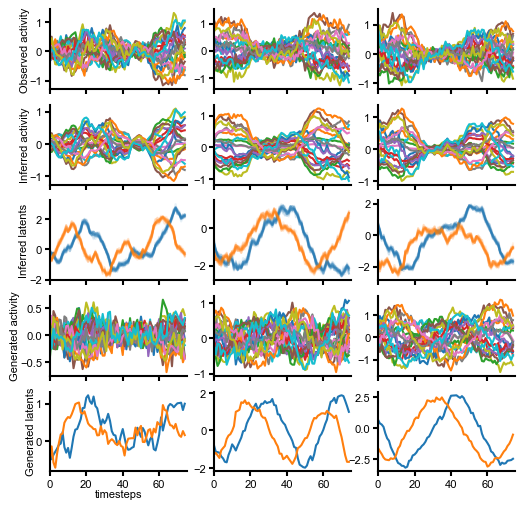

In [15]:
# plot data generated by our model next to evaluation data
# NOTE: we do not expect a timestep wise correspondance between data and generated samples
# as there we are plotting samples from a stochastic model. Instead we expect the distributions over samples to match.

alpha_particles = .1

fig, ax = plt.subplots(5, 3, figsize=(6,6))


# data
ax[0, 0].set_ylabel("Observed activity")
ax[0, 0].plot(dataset.data_eval[0].T)
ax[0, 1].plot(dataset.data_eval[1].T)
ax[0, 2].plot(dataset.data_eval[2].T)

# posterior
ax[1, 0].set_ylabel("Inferred activity")
ax[1, 0].plot(data_inf[0].T)
ax[1, 1].plot(data_inf[1].T)
ax[1, 2].plot(data_inf[2].T)

ax[2, 0].set_ylabel("Inferred latents")
ax[2, 0].plot(Z_inf_orth[0, 0], color='C0',alpha=alpha_particles)
ax[2, 1].plot(Z_inf_orth[1, 0], color='C0',alpha=alpha_particles)
ax[2, 2].plot(Z_inf_orth[2, 0], color='C0',alpha=alpha_particles)
ax[2, 0].plot(Z_inf_orth[0, 1], color='C1',alpha=alpha_particles)
ax[2, 1].plot(Z_inf_orth[1, 1], color='C1',alpha=alpha_particles)
ax[2, 2].plot(Z_inf_orth[2, 1], color='C1',alpha=alpha_particles)

# generated
ax[3, 0].set_ylabel("Generated activity")
ax[3, 0].plot(data_gen[0].T)
ax[3, 1].plot(data_gen[1].T)
ax[3, 2].plot(data_gen[2].T)

ax[4, 0].set_ylabel("Generated latents")
ax[4, 0].plot(Z_gen_orth[0].T)
ax[4, 1].plot(Z_gen_orth[1].T)
ax[4, 2].plot(Z_gen_orth[2].T)
ax[4, 0].set_xlabel("timesteps")

for i, a in enumerate(ax.flatten()):
    a.set_xlim(0, 75)
    if i<12:
        a.set_xticklabels([])


In [22]:
import numpy as np
import torch
import sys

sys.path.append("../")
from torch.utils.data import DataLoader
from evaluation.calc_stats import *
from vi_rnn.datasets import *
from vi_rnn.saving import load_model
from py_rnn.train import load_rnn
from vi_rnn.generate import generate
import matplotlib.pyplot as plt
from vi_rnn.utils import *
import matplotlib as mpl
from fixed_points.find_fixed_points_analytic import find_fixed_points_analytic
from fixed_points.stability import PL_Jacobian
from matplotlib.markers import MarkerStyle
from matplotlib.colors import colorConverter as cc
import copy

%matplotlib inline

In [23]:
# As we only trained for a couple of epochs we will load a pretrained model
# This was trained as above, but for 500 epochs
vae, training_params, task_params = load_model(
    "tutorial_data/tutorial_cont", load_encoder=False, backward_compat=True
)

using uniform init


In [24]:

vae = orthogonalise_network(vae)
rotation_matrix = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
# vae = rotate_basis_vectors(vae,rotation_matrix)
tau, pV, pU, pB, pI = get_loadings(vae)

In [28]:

# run the student RNN
with torch.no_grad():
    # run the student RNN
    Z, _, data_gen, rates_gen = generate(
        vae,
        u=None,
        x=dataset.data_eval,
        initial_state="posterior_mean",
        k=1,
    )
    Zn = Z.cpu().detach().numpy()[:, :, :, 0]
    data_gen = data_gen.cpu().detach().numpy()[:, :, :, 0]
    # z0 = torch.zeros(task_params["n_trials"], 2, 1)



# # convert to numpy
# Z_gen = Z_gen[:,:,:,0].cpu().detach().numpy()
# data_gen = data_gen[:,:,:,0].cpu().detach().numpy()

In [29]:
# Get all fixed points of student RNN
D_list, D_inds, z_list, n_inverses = find_fixed_points_analytic(
    np.array([tau, tau]), pV, pU, 0, pB
)

190
4
(760, 20)
(211, 20)
Found a fixed point
[ 0.05858488 -0.03892564]
Done, found 1 fixed points


In [40]:
# extract phase planes

u_in = np.zeros(2)
xlims = 3
ylims = 3
# X, Y, uGT, vGT, normGT = extract_phase_plane_rnn(rnn_reaching, xlims, ylims, inp=u_in)
X, Y, u, v, norm = extract_phase_plane_vae(vae, xlims, ylims, inp=None)

In [41]:
u_in.shape

(2,)

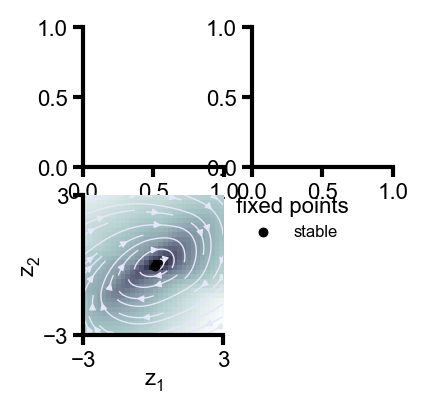

In [44]:
# Make panel c

# marker style
dot_s = 10
dot_z = 100
dot_ew = 0.4
dot_s_st = 20
dot_fill = "gainsboro"



T1 = 0



with mpl.rc_context(fname="matplotlibrc"):
    fig, ax = plt.subplots(2, 2, figsize=(2, 2), dpi=200)


    # Student
    ax[1, 0].imshow(
        norm,
        extent=[-xlims, xlims, -ylims, ylims],
        origin="lower",
        cmap="bone",
        vmax=np.max(norm),
        aspect="auto",
    )
    ax[1, 0].streamplot(
        X, Y, u, v, color="lavender", density=0.5, linewidth=0.5, arrowsize=0.5
    )
    ax[1, 0].set_box_aspect(1)
    ax[1, 0].spines[["right", "top"]].set_visible(False)
    ax[1, 0].set_xlim(-xlims, xlims)
    ax[1, 0].set_ylim(-ylims, ylims)
    ax[1, 0].set_xticks([-xlims, xlims])
    ax[1, 0].set_yticks([-ylims, ylims])
    ax[1, 0].set_xlabel(r"$z_1$")
    ax[1, 0].set_ylabel(r"$z_2$")


    ax[1, 1].set_box_aspect(1)
    ax[1, 1].axis("off")

    # for legend
    incl_stable = False
    incl_saddle = False
    incl_unstable = False
    """"""
    # Calculate stability of fixed points and plots
    for z in z_list:
        e, vec = np.linalg.eig(PL_Jacobian(pV, pU, -pB, np.diag(np.ones(2) * tau), z))
        if abs(e[0]) > 1 and abs(e[1]) > 1:
            if incl_unstable:
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c=dot_fill,
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o"),
                    zorder=dot_z,
                )
            else:
                incl_unstable = True
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c=dot_fill,
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o"),
                    zorder=dot_z,
                    label="unstable",
                )
        elif abs(e[0]) < 1 and abs(e[1]) < 1:
            if incl_stable:
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c="black",
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o"),
                    zorder=dot_z,
                )
            else:
                incl_stable = True
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c="black",
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o"),
                    zorder=dot_z,
                    label="stable",
                )
        else:  # saddle
            if incl_saddle:
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c=dot_fill,
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o", fillstyle="right"),
                    zorder=dot_z - 1,
                )
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c="black",
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o", fillstyle="left"),
                    zorder=dot_z - 1,
                )
            else:
                incl_saddle = True
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c=dot_fill,
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o", fillstyle="right"),
                    zorder=dot_z - 1,
                    label="saddle",
                )
                ax[1, 0].scatter(
                    z[0],
                    z[1],
                    s=dot_s,
                    c="black",
                    edgecolor="black",
                    lw=dot_ew,
                    marker=MarkerStyle("o", fillstyle="left"),
                    zorder=dot_z - 1,
                    label="saddle",
                )
    ax[1, 0].legend(title="fixed points", loc="upper right", bbox_to_anchor=(2, 1.1))
